# Is it Possible to Predict Accurate Future Prices of Magic: The Gathering Cards using machine learning?
## tl;dr Not really.
### Sumner Harris

Magic: The Gathering card prices vary over time and are dictated by their own small economy which is mostly driven by privately owned card shops. Card prices range from a few cents to thousands of dollars, and these prices can change drastically over time depending on the number of reprints of the card, new set releases, its game type legalities, and other features. Many players think of their cards as a sort of investemnt, often buying card packs for say, $20, with the hopes of pulling a hundred dollar card they can resell for a profit. 

The question this notebook aims to answer is: "Can I predict the future price of a MTG card to determine if it is a good investment?" E.g. If I buy this card from the shop now, can I resell it next year for more?

First, I will jump straight into fitting the time series data with various ML models and show how well they APPEAR to describe the data and compare to a baseline model. Next, I will go through a short statistical analysis of the price history and show that the data is likely to be a random walk, which means we cannot reasonably predict the future price of a card, especially not far into the future. Then, I will process the data by differencing it and refit the baseline, ML models.

# Data Acquisition

The first task is to acquire the price history data for your card of interest. You can get the price history from MTGGoldfish. On their website, navigate to a card you are interested in and copy the url. 

Using that url, the function I have written below will pull the raw html and extract the price vs time data.

I will save that to a file for future reference called "CARD_NAME_raw_data.txt" and the date vs. price data will be saved as "CARD_NAME_price_data.json"

In [1]:
import pandas as pd
import requests
import datetime
import re
import IPython
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['date.epoch'] = '0000-12-31'

def get_price_history(card_url,saved_file_name):
    """ Takes in a URL for a card from www.mtggoldfish.com 
    and returns the price for that card over time."""
    
    r = requests.get(card_url) # pull the html
    
    # write the raw html to a file
    with open(saved_file_name+'_raw_data.txt','w') as text_file:
        print(r.text,file=text_file)
    
    # reopen that raw data to begin the data extraction processes
    file = open(saved_file_name+'_raw_data.txt', 'r')

    #counter = 0
    # define a list for the starting and ending line indicies in the case of multiple datasets per page.
    start_index = [] 
    end_index = []

    for index, line in enumerate(file):
        if line.startswith('var d ='):
            start_index.append(index+1)
        if line.startswith('g = new Dygraph('):
            end_index.append(index)
            #counter += 1
            
    time_data = [] #initialize list of time data for each dataset on the page
    for i in range(len(start_index)):
        file = open(saved_file_name+'_raw_data.txt', 'r')
        time_data_partial = [] # the partial data is for 1 of the several data sets on the page
        for index, line in enumerate(file):
            if index >= start_index[i] and index <= end_index[i]-1:
                time_data_partial.append(line)
        time_data.append(time_data_partial)
        
    data_dict = {}
    for j in range(len(time_data)):
        sub_dict = {}
        date = []
        price = []
        for i in range(len(time_data[j])):
            if re.search(', (.*)";',time_data[j][i]) is not None:
                date.append(datetime.datetime.strptime(time_data[j][i][10:20], '%Y-%m-%d').date())
                #date.append(time_data[j][i][10:20])
                price.append(float(re.search(', (.*)";',time_data[j][i])[1]))
        sub_dict['Date'] = date
        sub_dict['Price'] = price
        data_dict[j]=sub_dict
    pd.DataFrame(data_dict[0]).to_json(saved_file_name+'_price_data.json') # save the price data to json
    print('Saved the raw html as:', saved_file_name+'_raw_data.txt')
    print('Saved the price history as:', saved_file_name+'_price_data.json')

We can use the above function to get the data for some random card I have chosen:  Tarmogoyf.
But first, I will write a simple function to load the saved json file.

In [2]:
# Very simple function that streamlines loading the from json with pandas using the card's name
def load_data(saved_file_name):
    df = pd.read_json(saved_file_name+'_price_data.json')
    return df

In [3]:
# URL of the card
URL = "https://www.mtggoldfish.com/price/Modern+Masters+2015/Tarmogoyf"

#Input the name of the card to format the saved file names
card_name = 'Tarmogoyf'

# Use the function get_price_history by passing the url and card name
get_price_history(URL,card_name)

# You can use the function load_data to bring the price history into a dataframe that we need to predict the future prices
df = load_data(card_name)
df['Price'] = df['Price']
print('Date shape:',df.shape)
df.head()

Saved the raw html as: Tarmogoyf_raw_data.txt
Saved the price history as: Tarmogoyf_price_data.json
Date shape: (1911, 2)


,Date,Price
0,2015-05-08,164.8
1,2015-05-09,164.8
2,2015-05-10,164.8
3,2015-05-11,164.8
4,2015-05-12,164.0


So now we have a nice, simple table to work with for this card. We can plot the data to visualize.

C:\Users\Sumner\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\Sumner\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


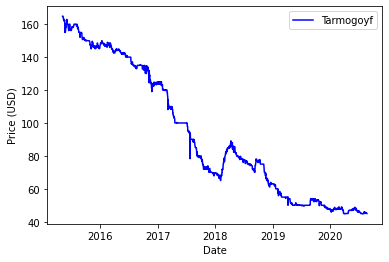

In [4]:
# plot the price data
time = df['Date']
price = df['Price']

plt.plot(time, price, '-b', label='Tarmogoyf')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
# uncomment below to zoom to a specific date range
#plt.xlim('2017-01-01','2018-02-01')
plt.show()

# Baseline: Naive/Persistence Model

We need to get a baseline model to compare with the more complicated AI networks to see if we get any improvement. I would first like to scale the price data to be in the range -1,1 (because that is needed for the other models) and split into training and test sets. I will use the first 75% of the data as the training set, and the rest as the test set.

Train/test shape: (1433, 1) (478, 1)


C:\Users\Sumner\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
C:\Users\Sumner\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


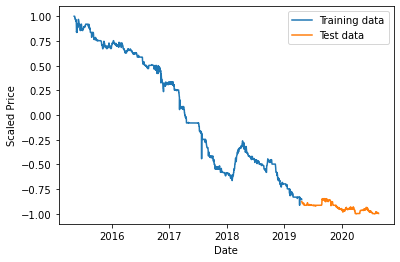

In [5]:
from sklearn.preprocessing import MinMaxScaler

def scale_split_baseline(dataframe, train_size=0.75):
    prices = df['Price'].values
    dates = df['Date']
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(prices.reshape(-1,1))

    train_size = int(len(data_scaled) * train_size)
    test_size = len(data_scaled) - train_size
    train, test = data_scaled[0:train_size], data_scaled[train_size:len(price)]
    print('Train/test shape:', train.shape, test.shape)

    train_time = dates[:len(train)]
    test_time = dates[len(train):]
    
    return train_time, train, test_time, test

train_time, train, test_time, test = scale_split_baseline(df)

plt.plot(train_time,train,label='Training data')
plt.plot(test_time,test,label='Test data')
plt.ylabel('Scaled Price')
plt.xlabel('Date')
plt.legend()
plt.show()

Next we can create a simple persitence model where the price at time t+1 is just the price at time t. Then I will plot the test data with the predictions to visualize the results.

Persistence MSE: 0.000038


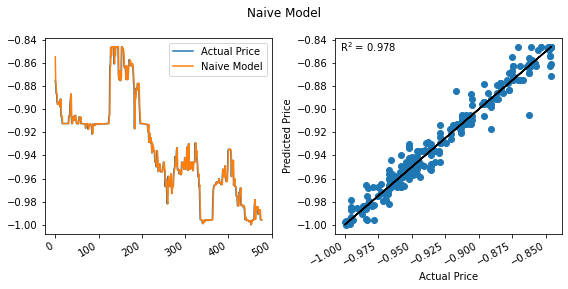

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def persistence_model(train, test):
    predictions = []
    history = train[-1]
    for i in range(len(test)):
        yhat = history
        predictions.append(yhat)
        history = test[i]
    return predictions

predictions = persistence_model(train, test)

test_error = mean_squared_error(test, predictions)

def plot_results(test_time, test, predictions,title):
    
    r2 = r2_score(test, predictions)
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot(test, label='Actual Price')
    ax[0].plot(predictions, label=title)
    #ax[0].set_xlim('2019-07-01','2019-07-12')
    ax[0].legend()

    ax[1].scatter(test, predictions)
    ax[1].plot(predictions,predictions,'k')
    ax[1].set_xlabel('Actual Price')
    ax[1].set_ylabel('Predicted Price')
    #ax[1].text(-1,-0.85, 'R$^2$ = {:.3f}'.format(r2))
    ax[1].text(0.15, 0.95, 'R$^2$ = {:.3f}'.format(r2), horizontalalignment='center',
         verticalalignment='center', transform=ax[1].transAxes)

    fig.suptitle(title)
    fig.autofmt_xdate()
    fig.tight_layout()
    
print('Persistence MSE: %.6f' % test_error)
plot_results(test_time, test, predictions, 'Naive Model')
#plot_results(train_time, train, predictions_train,'Train Naive')
plt.show()

We can see that our naive model seems to perform well with an MSE of 3.8e-5 for predictions. When you compare the predicted price to the actual price, there seems to be a good predictive power of this baseline model, with R2 = 0.978.

In the cell below, I create dictionaries of mse values for each of the models to compare later.

In [7]:
test_performance = {}
performance = {}

test_performance['Baseline']=[test_error]
performance['Baseline']=[test_error]

# Create a lag feature for ML models
I need to turn this time series into a surpervised learning problem. I will aim to predict the price of the card 1 day into the future, and use the price the day before as the time-lagged, feature. The pandas shift() function can do this, and then I will drop the NaN that comes from the shift.

In [8]:
df_lagged = df.copy()
df_lagged['Price t+1'] = df_lagged['Price'].shift(1)
df_lagged.dropna(inplace=True)

df_lagged.head()

,Date,Price,Price t+1
1,2015-05-09,164.8,164.8
2,2015-05-10,164.8,164.8
3,2015-05-11,164.8,164.8
4,2015-05-12,164.0,164.8
5,2015-05-13,164.0,164.0


Next, split into training and test sets and use the same scaling as before. We also need to reshape to be 3D for input into the Keras models.

In [9]:
# remove the date column to make it easier to process the df
dates = df_lagged.pop('Date')

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_lagged)

train_size = int(len(data_scaled) * 0.75)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size], data_scaled[train_size:len(price)]

# for multiple lag features, uncomment below
#X_train, y_train = train[:,:-1], train[:,-1]
#X_test, y_test = test[:,:-1], test[:,-1]
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#n_features = X_train.shape[2]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]
X_train = np.reshape(X_train,(-1,1,1))
X_test = np.reshape(X_test,(-1,1,1))
n_features = 1

train_time = dates[:len(X_train)]
test_time = dates[len(X_train):]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1432, 1, 1) (1432,) (478, 1, 1) (478,)


# Linear Model
The next simplest model we could try past the baseline is just a linear model. We can do this in Keras by just having a dense layer with 1 node.

In [10]:
import tensorflow as tf

linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Dense(units=1,input_shape=(1,n_features), activation='linear'))

linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 1)              2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Below, I define a compile and fit function since I am going to be doing the repeatedly. I will train with 50 epochs and set up an early stopping callback to prevent the models from training for too long.

In [11]:
def compile_fit(model, X_train, y_train):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mse',patience=1)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1,
                        shuffle=False,callbacks=[early_stopping])
    return history

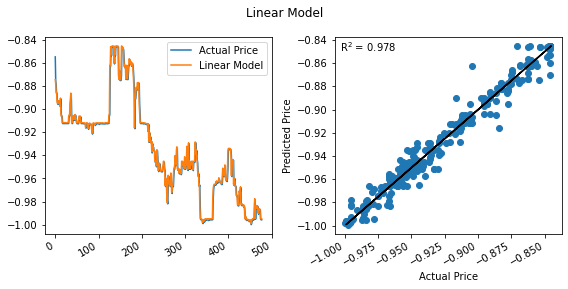

45/45 [==============================] - 0s 1ms/step - loss: 2.7554e-04 - mse: 2.7554e-04 - mae: 0.0077


In [12]:
linear_history = compile_fit(linear_model, X_train, y_train)
IPython.display.clear_output()

linear_predictions = linear_model.predict(X_test).flatten()
plot_results(test_time, y_test, linear_predictions,'Linear Model')
plt.show()

test_performance['Linear'] = linear_model.evaluate(X_test,y_test)
performance['Linear'] = linear_model.evaluate(X_train,y_train)

This linear model is comparable in performance to the baseline, with a slightly smaller mse with an R2 of 0.977. Looks promising so far, right?

# Neural Network model

Next, I will use an small artifcial neural network with 12 neurons. In Keras, you use a Dense layer for this and then output to a single Dense node.

In [13]:
import tensorflow as tf

nn_model = tf.keras.Sequential()
nn_model.add(tf.keras.layers.Dense(12,input_shape=(1,n_features)))
nn_model.add(tf.keras.layers.Dense(1))

nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 12)             24        
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


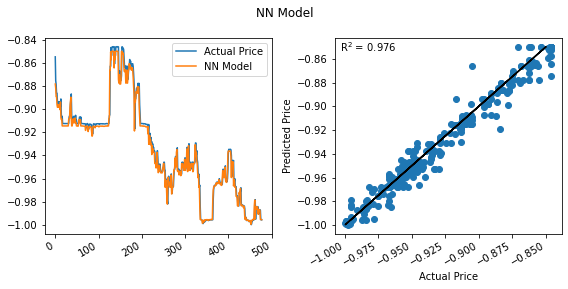

45/45 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0308


In [14]:
nn_history = compile_fit(nn_model, X_train, y_train)
IPython.display.clear_output()

nn_predictions = nn_model.predict(X_test).flatten()
plot_results(test_time, y_test, nn_predictions,'NN Model')
plt.show()

test_performance['NN'] = nn_model.evaluate(X_test,y_test)
performance['NN'] = nn_model.evaluate(X_train,y_train)

Again, we seem to have good perfomance with the NN model, similar to the baseline and linear models.

# Deep NN model
We can add a bit more complexity by increasing the number of hidden layers in out NN model. I will keep the 12 neurons in the first layer, and then add two layers with 3 neurons each. This is a somewhat arbitrary choice, I wanted 2 hidden layers and played around with this a bit to find a good number of neurons per layer.

In [15]:
dnn_model = tf.keras.Sequential()
dnn_model.add(tf.keras.layers.Dense(12,input_shape=(1,n_features)))
dnn_model.add(tf.keras.layers.Dense(3))
dnn_model.add(tf.keras.layers.Dense(3))
dnn_model.add(tf.keras.layers.Dense(1))

dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 12)             24        
_________________________________________________________________
dense_4 (Dense)              (None, 1, 3)              39        
_________________________________________________________________
dense_5 (Dense)              (None, 1, 3)              12        
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              4         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


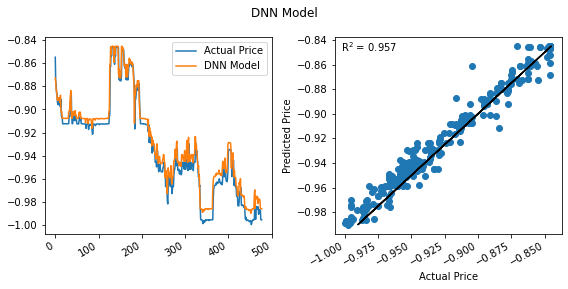

45/45 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0539


In [16]:
# Fit the model
dnn_history = compile_fit(dnn_model, X_train, y_train)
IPython.display.clear_output()

dnn_predictions = dnn_model.predict(X_test).flatten()
plot_results(test_time, y_test, dnn_predictions,'DNN Model')
plt.show()

test_performance['DNN'] = dnn_model.evaluate(X_test,y_test)
performance['DNN'] = dnn_model.evaluate(X_train,y_train)

We still have pretty good performance, but this model is worse than the simpler ones so far. 

# LSTM model
Lastly we can use a long short term memory RNN. LSTM models are pretty common for sequential data. I will just use 12 LSTM units.

In [17]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(12, input_shape=(1, n_features), activation='relu',return_sequences=False))
lstm_model.add(tf.keras.layers.Dense(1))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                672       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


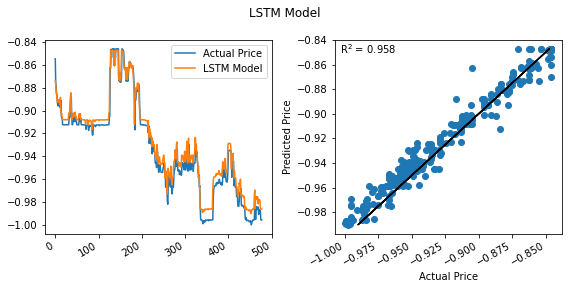

45/45 [==============================] - 0s 2ms/step - loss: 8.7677e-04 - mse: 8.7677e-04 - mae: 0.0243


In [18]:
# Fit the model
lstm_history = compile_fit(lstm_model, X_train, y_train)
IPython.display.clear_output()

lstm_predictions = lstm_model.predict(X_test).flatten()
plot_results(test_time, y_test, lstm_predictions,'LSTM Model')
plt.show()

test_performance['LSTM'] = lstm_model.evaluate(X_test,y_test)
performance['LSTM'] = lstm_model.evaluate(X_train,y_train)

Similar story here with the LSTM model. It does okay but is definitely the worst so far. We can see a vertical shift in the predictions which probably means that the LSTM model is very overfit to the training data

# Needlessly complicated DNN-LSTM model, because why not.

I can further increase the complexity by mixing my ideas for the DNN and LSTM networks, purely for demonstration purposes at this point since we are already seeing that the baseline model is superior. This model starts with a 12 node dense layer, feeds into a 12 unit LSTM, then a 3 node dense layers, another 12 unit LSTM, and last hidden layer is another 3 node dense layer. 

In [19]:
dnn_lstm_model = tf.keras.Sequential()
dnn_lstm_model.add(tf.keras.layers.Dense(12,input_shape=(1, n_features)))
dnn_lstm_model.add(tf.keras.layers.LSTM(12, input_shape=(1, n_features), activation='relu',return_sequences=True))
dnn_lstm_model.add(tf.keras.layers.Dense(3))
dnn_lstm_model.add(tf.keras.layers.LSTM(12, input_shape=(1, n_features), activation='relu',return_sequences=True))
dnn_lstm_model.add(tf.keras.layers.Dense(3))
dnn_lstm_model.add(tf.keras.layers.Dense(1))

dnn_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1, 12)             24        
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 12)             1200      
_________________________________________________________________
dense_9 (Dense)              (None, 1, 3)              39        
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 12)             768       
_________________________________________________________________
dense_10 (Dense)             (None, 1, 3)              39        
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1)              4         
Total params: 2,074
Trainable params: 2,074
Non-trainable params: 0
____________________________________________________

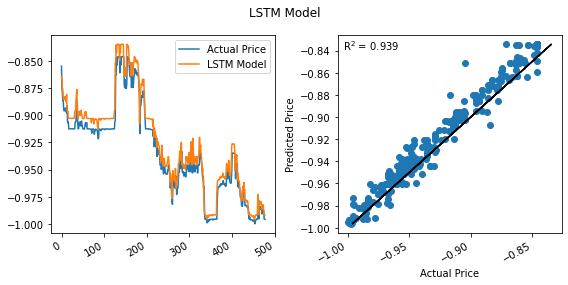

45/45 [==============================] - 0s 2ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0811


In [20]:
# Fit the model
dnn_lstm_history = compile_fit(dnn_lstm_model, X_train, y_train)
IPython.display.clear_output()

dnn_lstm_predictions = dnn_lstm_model.predict(X_test).flatten()
plot_results(test_time, y_test, dnn_lstm_predictions,'LSTM Model')
plt.show()

test_performance['DNN-LSTM'] = dnn_lstm_model.evaluate(X_test,y_test)
performance['DNN_LSTM'] = dnn_lstm_model.evaluate(X_train,y_train)

Overall, worse performance then other models. Granted, there are a lot of hyperparameters to tune here that I am not spending time with.

# Model Results Summary

Below, you can see the comparison of the mse values for the train and test set for all the models. Clearly, the baseline outperforms all other models. The mse on the test set gets worse with increased complexity, with the linear model being the next best option, followed by the LSTM and NN models. The DNN and complicated DNN-LSTM models are the worst. 

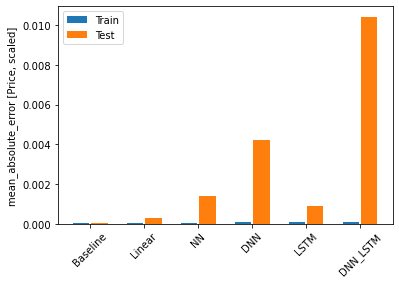

In [21]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_square_error'
metric_index = lstm_model.metrics_names.index('loss')

test_mse = [v[metric_index] for v in test_performance.values()]
train_mse = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, scaled]')
plt.bar(x - 0.17, test_mse, width, label='Train')
plt.bar(x + 0.17, train_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.show()

One thing to note is that the train mse is much lower than the test mse for all cases except the baseline, so these models are liekly just overfitting the training data.

It would seem that any of these models would do okay to predict the price of the card tomorrow based on the predicted vs actual price plots. But let's take another look at the data...

# Statistical Analysis

As I mentioned in the beginning of this notebook, the Magic card data seems to pretty much be a random walk process. You can not predict the future values for random walks. But then how is it that our ML models seem to be good predictors? 

First, I will generate artifical price data with a random walk process and and fit an LSTM model to it to demonstrate that it seems to still work, even though we now know it can't possibly predict future points.

Next, I will compare the autocorrelation of the random walk and card data and show that there is strong evidence that the card data is a random walk.

Below, I generate a random walk data set with the same length and starting price as the card we were using.

C:\Users\Sumner\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


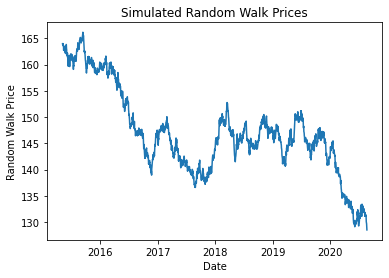

In [22]:
# Generate random steps with mean=0 and standard deviation=1, and the same length as our price data
np.random.seed(7)
steps = np.random.normal(loc=0, scale=0.5, size=len(df)-1)

# Set first element to the same first price as our card
steps[0] = 164 #df['Price'][0]

# Simulate stock prices, P with a starting price of 100
random_walk = 0 + np.cumsum(steps)

# Create a dataframe like our card data

df2 = pd.DataFrame({'Date':dates, 'Price':random_walk})

plt.plot(dates, random_walk)
plt.title("Simulated Random Walk Prices")
plt.xlabel('Date')
plt.ylabel('Random Walk Price')
plt.show()

Now, I will prepare this data the same way as I would for the LSTM model and fit it.

In [23]:
df_lagged = df2.copy()
df_lagged['Price t+1'] = df_lagged['Price'].shift(1)
df_lagged.dropna(inplace=True)

# remove the date column to make it easier to process the df
dates = df_lagged.pop('Date')

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_lagged)

train_size = int(len(data_scaled) * 0.75)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size], data_scaled[train_size:len(price)]

# for multiple lag features, uncomment below
#X_train, y_train = train[:,:-1], train[:,-1]
#X_test, y_test = test[:,:-1], test[:,-1]
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#n_features = X_train.shape[2]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]
X_train = np.reshape(X_train,(-1,1,1))
X_test = np.reshape(X_test,(-1,1,1))
n_features = 1

train_time = dates[:len(X_train)]
test_time = dates[len(X_train):]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1431, 1, 1) (1431,) (478, 1, 1) (478,)


# Fit Random Walk data with our LSTM

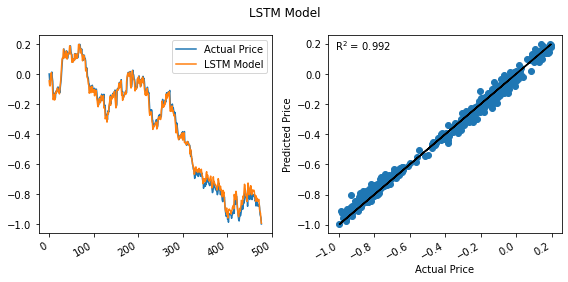

45/45 [==============================] - 0s 2ms/step - loss: 9.2557e-04 - mse: 9.2557e-04 - mae: 0.0243


In [24]:
# Fit the model
RW_lstm_model = tf.keras.Sequential()
RW_lstm_model.add(tf.keras.layers.LSTM(12, input_shape=(1, n_features), activation='relu',return_sequences=False))
RW_lstm_model.add(tf.keras.layers.Dense(1))

RW_lstm_history = compile_fit(RW_lstm_model, X_train, y_train)
IPython.display.clear_output()

RW_lstm_predictions = RW_lstm_model.predict(X_test).flatten()
plot_results(test_time, y_test, RW_lstm_predictions,'LSTM Model')
plt.show()

test_performance['RW-LSTM'] = RW_lstm_model.evaluate(X_test,y_test)
performance['RW-LSTM'] = RW_lstm_model.evaluate(X_train,y_train)

So our LSTM model performs really well with our random walk data but, in this case, we are absoluetly certain that the model has learned nothing from the data because we randomly generated it!

Let's look at the autocorrelation of the random walk data and compare that to the card data.

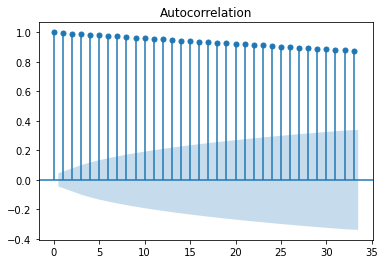

In [25]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(random_walk)
plt.show()

Above is the auto correlation of the random walk data. Each point is highly correlated to the point before and the ACF decays slowly.

Now we do the same for the card training data.

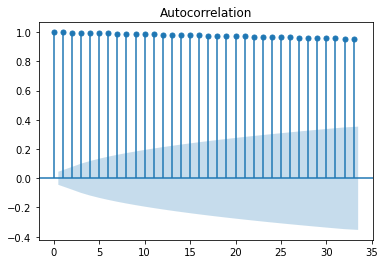

In [26]:
df = load_data(card_name)

plot_acf(df['Price'])
plt.show()

The card data has a similar ACF, indicating strong correlation of a point to the next point. This is evidence that we are dealing with random walk data and that our models are not actually predicting anything.

A better way to deal with our card data would be to predict the difference in the price from day to day, as is typically done when modeling stock prices. We can generate the differenced data easily with pandas and take another look at the autocorrelations.

# Differencing the Data

First, I want to difference the random walk data I generated and look at the autocorrelation.

In [27]:
df2['Price'] = df2['Price'].diff()
df2=df2.dropna()

C:\Users\Sumner\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Text(0.5, 1.0, 'Differenced Random Walk')

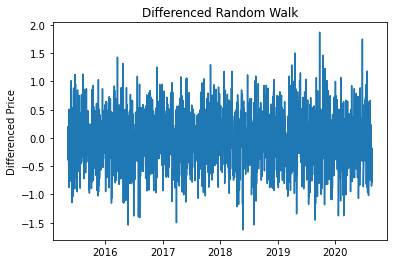

In [28]:
plt.plot(df2['Date'],df2['Price'])
plt.ylabel('Differenced Price')
plt.title('Differenced Random Walk')

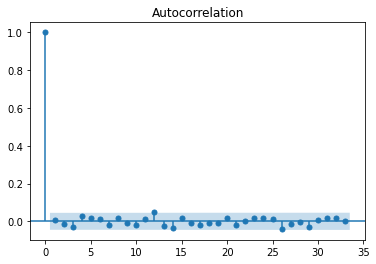

In [29]:
plot_acf(df2['Price'])
plt.show()

When we look at the differenced random walk data's ACF, we can see that there are no strong correlations in the data. In this case, there are statistically significant points at lag values of 12 and 26 but we would expect about 5% of points to be like that anyway.

Next, lets difference the card data.

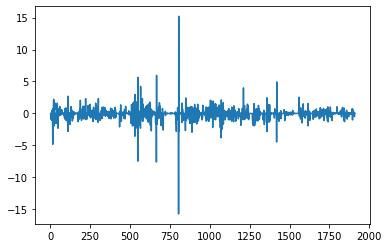

In [30]:
df = load_data(card_name)
df['Price'] = df['Price'].diff()
df = df.dropna()
plt.plot(df['Price'])
plt.show()

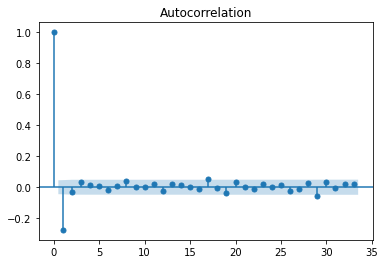

In [31]:
plot_acf(df['Price'])
plt.show()

In the case of the card data, we have a significant negative correlation for the first lag value and the rest are uncorrelated except for some fringe values at 17, and 29. So this is not exactly similar to our random walk, but remeber that there was an obvious downward trend in the card data the explains the negative correlation for the previous day.

# ML Models Take Two - Differenced Data

I will now repeat everything I did with the raw card data with the differenced card data and see if our ML models can truly predict the future price of the card.

Train/test shape: (1432, 1) (478, 1)


C:\Users\Sumner\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
C:\Users\Sumner\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


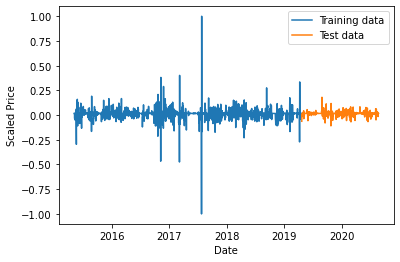

In [32]:
train_time, train, test_time, test = scale_split_baseline(df)

plt.plot(train_time,train,label='Training data')
plt.plot(test_time,test,label='Test data')
plt.ylabel('Scaled Price')
plt.xlabel('Date')
plt.legend()
plt.show()

# Baseline - Differenced

Persistence MSE: 0.001243


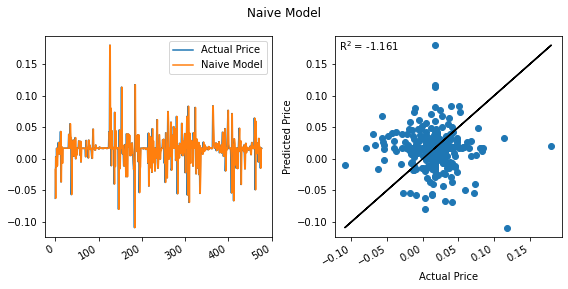

In [33]:
predictions = persistence_model(train, test)

test_error = mean_squared_error(test, predictions)
    
print('Persistence MSE: %.6f' % test_error)
plot_results(test_time, test, predictions, 'Naive Model')
#plot_results(train_time, train, predictions_train,'Train Naive')
plt.show()

This time, if we look at the predicted price vs actual price plot, we see that the baseline model has essentially no predictive power. Hopefullly the ML models can learn some sort of pattern from the differenced data and make an improvement over the baseline.

In [34]:
test_performance = {}
performance = {}

test_performance['Baseline']=[test_error]
performance['Baseline']=[test_error]

Now I'll just redo the data processing with the differenced data.

In [35]:
df_lagged = df.copy()
df_lagged['Price t+1'] = df_lagged['Price'].shift(1)
df_lagged.dropna(inplace=True)

df_lagged.head()

,Date,Price,Price t+1
2,2015-05-10,0.00,0.0
3,2015-05-11,0.00,0.0
4,2015-05-12,-0.80,0.0
5,2015-05-13,0.00,-0.8
6,2015-05-14,-1.01,0.0


In [36]:
# remove the date column to make it easier to process the df
dates = df_lagged.pop('Date')

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_lagged)

train_size = int(len(data_scaled) * 0.75)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size], data_scaled[train_size:len(price)]

# for multiple lag features, uncomment below
#X_train, y_train = train[:,:-1], train[:,-1]
#X_test, y_test = test[:,:-1], test[:,-1]
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#n_features = X_train.shape[2]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]
X_train = np.reshape(X_train,(-1,1,1))
X_test = np.reshape(X_test,(-1,1,1))
n_features = 1

train_time = dates[:len(X_train)]
test_time = dates[len(X_train):]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1431, 1, 1) (1431,) (478, 1, 1) (478,)


# Linear Model - Differenced

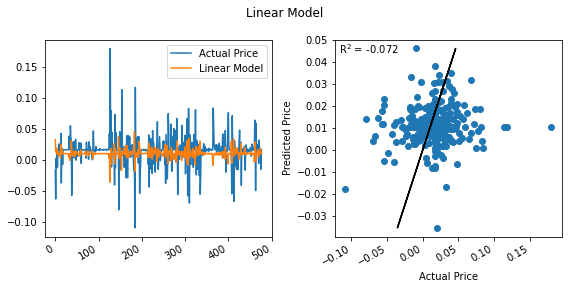

45/45 [==============================] - 0s 2ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0325


In [37]:
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Dense(units=1,input_shape=(1,n_features), activation='linear'))

linear_history = compile_fit(linear_model, X_train, y_train)
IPython.display.clear_output()

linear_predictions = linear_model.predict(X_test).flatten()
plot_results(test_time, y_test, linear_predictions,'Linear Model')
plt.show()

test_performance['Linear'] = linear_model.evaluate(X_test,y_test)
performance['Linear'] = linear_model.evaluate(X_train,y_train)

The linear model doesn't do much better than the baseline, moving on.

# NN Model - Differenced

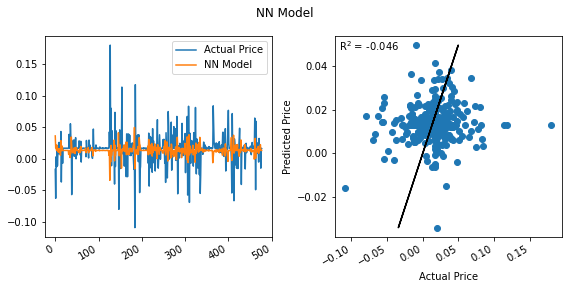

45/45 [==============================] - 0s 1ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0321


In [38]:
nn_model = tf.keras.Sequential()
nn_model.add(tf.keras.layers.Dense(12,input_shape=(1,n_features)))
nn_model.add(tf.keras.layers.Dense(1))

nn_history = compile_fit(nn_model, X_train, y_train)
IPython.display.clear_output()

nn_predictions = nn_model.predict(X_test).flatten()
plot_results(test_time, y_test, nn_predictions,'NN Model')
plt.show()

test_performance['NN'] = nn_model.evaluate(X_test,y_test)
performance['NN'] = nn_model.evaluate(X_train,y_train)

# DNN Model - Differenced

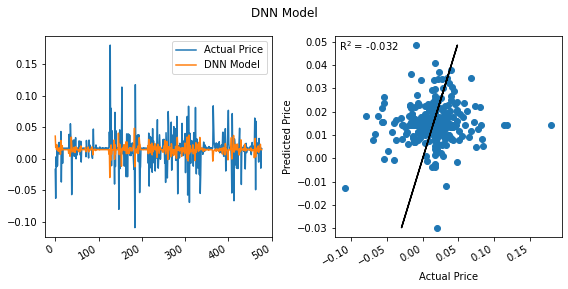

45/45 [==============================] - 0s 1ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0317


In [39]:
# Fit the model
dnn_model = tf.keras.Sequential()
dnn_model.add(tf.keras.layers.Dense(12,input_shape=(1,n_features)))
dnn_model.add(tf.keras.layers.Dense(3))
dnn_model.add(tf.keras.layers.Dense(3))
dnn_model.add(tf.keras.layers.Dense(1))

dnn_history = compile_fit(dnn_model, X_train, y_train)
IPython.display.clear_output()

dnn_predictions = dnn_model.predict(X_test).flatten()
plot_results(test_time, y_test, dnn_predictions,'DNN Model')
plt.show()

test_performance['DNN'] = dnn_model.evaluate(X_test,y_test)
performance['DNN'] = dnn_model.evaluate(X_train,y_train)

Same situation as above with the DNN.

# LSTM Model - Differenced

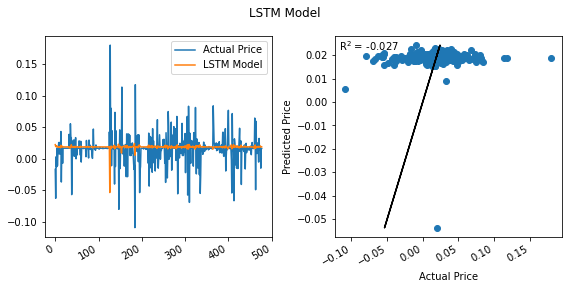

45/45 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0294


In [40]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(12, input_shape=(1, n_features), activation='relu',return_sequences=False))
lstm_model.add(tf.keras.layers.Dense(1))

lstm_history = compile_fit(lstm_model, X_train, y_train)
IPython.display.clear_output()

lstm_predictions = lstm_model.predict(X_test).flatten()
plot_results(test_time, y_test, lstm_predictions,'LSTM Model')
plt.show()

test_performance['LSTM'] = lstm_model.evaluate(X_test,y_test)
performance['LSTM'] = lstm_model.evaluate(X_train,y_train)

Our LSTM model predicts more or less the same value for every point.

# Needlessly complicated DNN-LSTM model, because why not - Differenced

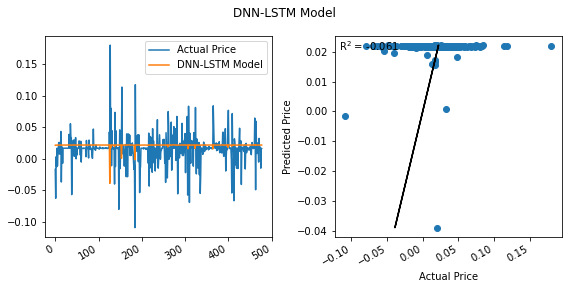

45/45 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0306


In [41]:
# Fit the model
dnn_lstm_model = tf.keras.Sequential()
dnn_lstm_model.add(tf.keras.layers.Dense(12,input_shape=(1, n_features)))
dnn_lstm_model.add(tf.keras.layers.LSTM(12, input_shape=(1, n_features), activation='relu',return_sequences=True))
dnn_lstm_model.add(tf.keras.layers.Dense(3))
dnn_lstm_model.add(tf.keras.layers.LSTM(6, input_shape=(1, n_features), activation='relu',return_sequences=True))
dnn_lstm_model.add(tf.keras.layers.Dense(3))
dnn_lstm_model.add(tf.keras.layers.Dense(1))

dnn_lstm_history = compile_fit(dnn_lstm_model, X_train, y_train)
IPython.display.clear_output()

dnn_lstm_predictions = dnn_lstm_model.predict(X_test).flatten()
plot_results(test_time, y_test, dnn_lstm_predictions,'DNN-LSTM Model')
plt.show()

test_performance['DNN-LSTM'] = dnn_lstm_model.evaluate(X_test,y_test)
performance['DNN_LSTM'] = dnn_lstm_model.evaluate(X_train,y_train)

Similar to the LSTM model, this model predicts a somewhat constant value but with a positive shift. Still, basically no predictive power.

# Model Results Summary
Below is the summary of the mse for each of these models, fitted with the differenced data. The clear winner here is the baseline model with all the others having a much greater error on the test set.

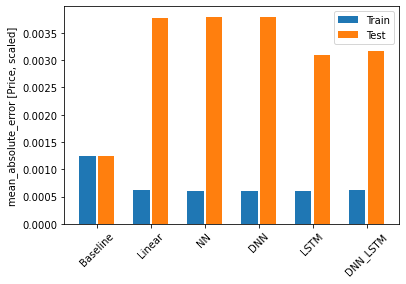

In [42]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_square_error'
metric_index = lstm_model.metrics_names.index('loss')

test_mse = [v[metric_index] for v in test_performance.values()]
train_mse = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, scaled]')
plt.bar(x - 0.17, test_mse, width, label='Train')
plt.bar(x + 0.17, train_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.show()

# Conclusion

Can you use machine learning predict the price of a Magic: The Gathering card a year from now to determine if buying it would be a good investment? No, not really. However, you can be tricked into believing you can if you don't carefully inspect your data. 

To summarize:

I pulled the price history data for a magic card and modeled the price over time with naive, linear, NN, DNN, LSTM, and DNN-LSTM models. None of the ML models outperformed the baseline, but all seemed to have good predictive power when looking at the predicted price vs. actual price plots.

Further analysis of the data reveals that the price data (at least for this particular card) is essential a random walk, and so future prices cannot be reasonably predicted with these models. 

To emphasize this point, I generated artifical price data with a random walk model and fit it with an LSTM which also seemed to have good predictive power, even though we know that it isn't true. 

As a real test, I then differenced the card data and repeated the ML models to give a true evaluation of their predictive power. Still, the baseline model outperformed all the ML models. Granted, you could spend a long time tuning hyperparameters to try to get better results, but the data is essential a random walk and so there is no real reason to spend your time with this.

So no, you can't reasonably predict the future price of a Magic card with ML techniques... at least in the case of this one card. I invite you to try with any of the other ~20,000 magic cards and see if any have a pattern that can be learned by ML.